# Interpolated time series on cadCAD

*Danilo Lessa Bernardineli*

---

This notebook shows how you can include a time series in a simulation when you have sparse temporal records.

## Dependences

On this block, we import all the libraries that we need, and also we set the length of the simulation.

In [1]:
%%capture
!pip install cadCAD

In [2]:
import numpy as np
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [3]:
SIMULATION_TIMESTEPS = 100

### Load the timeseries

In [4]:
# The input for interpolating the simulation time series.
# It is a sequence of events encoded by a list of tuples.
records = [('2020-01-01', 10.5),
           ('2020-02-10', 1.3),
           ('2020-02-15', 100.2),
           ('2020-03-10', 9.3)]

# Transform the list of tuples to a Pandas series
timeseries = (pd.DataFrame(records, columns=['date', 'value'])
                .assign(date=lambda df: pd.to_datetime(df.date))
                .set_index('date')
                .value)

In [5]:
# Show the first five values
timeseries.head(5)

date
2020-01-01     10.5
2020-02-10      1.3
2020-02-15    100.2
2020-03-10      9.3
Name: value, dtype: float64

### Interpolate timeseries

Now, we create a function that has a time series provided by the user and returns a interpolated time series.

In [6]:
def interpolate_from_timeseries(series: pd.Series, N: int,
                                start: str = None, end: str = None) -> pd.Series:
    """
    Given an series with datetime index, generate an interpolated series with
    N points, and between start and end (min/max if None).
    """
    if start == None:
        start = series.index.min()
    if end == None:
        end = series.index.max()

    # Create a interpolator object instance
    interpolator = interp1d(series.index.map(lambda t: t.value), series.values)

    # Generate equidistant dates between the provided start and end range
    interpolated_dates = pd.date_range(start=start, end=end, periods=N)

    # Generate a NumPy array of interpolated values for each generated date
    interpolated_values = interpolator(
        interpolated_dates.map(lambda t: t.value))
    
    # Transform the interpolated values array into a Pandas series
    interpolated_series = pd.Series(
        interpolated_values, index=interpolated_dates)
    return interpolated_series

## cadCAD model

For sake of simplicity, we use a simple model:

$v(t) = s(t) + \mathcal{N}(\mu,  \sigma)$

where $s(t)$ is the actual interpolated value, and $\mathcal{N}$ is a random gaussian number.

In [7]:
# Get the values from the interpolated series for a provided timeseries and N
interpolated_series = (interpolate_from_timeseries(timeseries, SIMULATION_TIMESTEPS)
                       .reset_index(drop=True)
                       .to_dict())

sys_params = {
    'stochastic_mean': [2.0],
    'stochastic_stdev': [0.5],
    'timestep_series': interpolated_series,
}

genesis_states = {
    'something': 0,
}


def s_something(params, substep, state_history, prev_state, policy_input):
    """
    State Update Function for putting a random error in the interpolated series
    """
    # Dependences
    series = params['timestep_series']
    mean = params['stochastic_mean']
    sigma = params['stochastic_stdev']
    current_timestep = prev_state['timestep']

    # Logic
    current_value = series[current_timestep]
    new_value = float(current_value + np.random.normal(mean, sigma))
    
    return ('something', new_value)


partial_state_update_blocks = [
    {
        'label': 'Make the timeseries fuzzy',
        'policies': {
            
        },
        'variables': {
            'something': s_something
        }
    }
]

sim_config = {
    'N': 1,
    'M': sys_params,
    'T': range(SIMULATION_TIMESTEPS)
}

## Model execution

In [8]:
from cadCAD.configuration.utils import config_sim

sim_params = config_sim(sim_config)

from cadCAD.configuration import Experiment

exp = Experiment()
exp.append_configs(
    sim_configs=sim_config,
    initial_state=genesis_states,
    partial_state_update_blocks=partial_state_update_blocks
)

from cadCAD import configs
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx, configs=configs)
raw_system_events, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (100, 3, 1, 1)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.02s


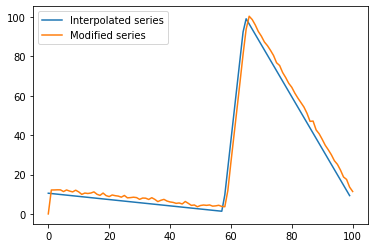

In [9]:
# Plot data
data = pd.DataFrame(raw_system_events)
pd.Series(interpolated_series).plot(label='Interpolated series')
data.something.plot(label='Modified series')
plt.legend()
plt.show()